In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from data_builder import *
from utils import *
from model import *
%matplotlib inline

from data_builder import *
from utils import *
from model import *
import numpy as np
import matplotlib.pyplot as plt

import pickle


In [2]:
sns.set_context('talk')
sns.set_palette('deep')

In [3]:
def pend_chaos(num_trajectories, T_max, dt, srate, seed):
    """1-body pendulum with time system"""

    def hamiltonian_fn(coords):
        # q, p, t = np.split(coords, 3)
        H = 9.81 * (1 - cos(coords[:,0])) + (coords[:,1]** 2) / 2 + 3 * cos(np.pi * coords[:,2])  # pendulum hamiltonian
        return H

    def calc_deri(yvec, time):
        mass = 1  # kg
        b = 1
        g = 9.81
        r = 1
        f0 = 1
        omega = 3

        return (yvec[1],  -yvec[0] + f0 * np.cos(omega * time) / (mass * r))

    def get_trajectory(radius=None, y0=None):
        # get initial state
        if y0 is None:
            y0 = np.random.rand(2) * 2 - 1
        if radius is None:
            radius = np.sqrt(np.random.uniform(0.5, 1.5))  # np.random.rand() * 0.9 + 0.1  # sample a range of radii
        y0 = y0 / np.sqrt((y0 ** 2).sum()) * (radius)  ## set the appropriate radius
        time_vec = np.arange(0, T_max, dt)
        yinit = y0
        accum = odeint(calc_deri, yinit, time_vec)
        derivs = [calc_deri(accum[i], time_vec[i]) for i in range(len(accum))]
        return accum, derivs, time_vec

    def get_dataset(num_trajectories, T_max, dt):
        data = {'meta': locals()}
        # randomly sample inputs
        np.random.seed(seed)
        data = {}
        xs, dxs, times, energies = [], [], [], []
        for s in range(num_trajectories):
            x, dx, time = get_trajectory()
            # x += np.random.randn(*x.shape) * noise_std
            xs.append(x)
            dxs.append(dx)
            energies.append(hamiltonian_fn(np.concatenate([x,np.reshape(time,(-1,1))],1)))
            times.append(time)
        data['x'] = np.concatenate(xs)
        data['dx'] = np.concatenate(dxs)
        data['tvalues'] = np.concatenate(times)
        data['energy'] = np.concatenate(energies)
        return data

    return get_dataset(num_trajectories, T_max, dt)


In [4]:
model = torch.load('HNN_td_force')
model.eval()

HNN(
  (mlp1): Linear(in_features=3, out_features=200, bias=True)
  (mlp2): Linear(in_features=200, out_features=200, bias=True)
  (mlp3): Linear(in_features=200, out_features=200, bias=True)
  (mlp4): Linear(in_features=200, out_features=1, bias=True)
)

In [5]:
T_max_t//dt

NameError: name 'T_max_t' is not defined

In [6]:
"""
Author: ***
Code to produce the results obtained in VIGN: Variational Integrator Graph Networks

"""

# %%

num_trajectories = 25
n_test_traj = 10
num_nodes = 2
T_max = 3.05
T_max_t = 10.1
dt = 0.1
srate = 0.1

bs = int(T_max_t//dt)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# train_data = pend_chaos(num_trajectories, T_max, dt, srate, 0)#pendulum(num_trajectories, T_max, dt, srate, noise_std=0, seed=3)
valid_data = pend_chaos(n_test_traj, T_max_t, dt, srate, 1)#pendulum(n_test_traj, T_max_t, dt, srate, noise_std=0, seed=5)

# tnow, tnext, tenergy, tdx,tevals = nownext(train_data, num_trajectories, T_max, dt, srate)
vnow, vnext, venergy, vdx,vevals = nownext(valid_data, n_test_traj, T_max_t, dt, srate)


# traindat = pendpixdata(tnow, tnext, tenergy, tdx,tevals)
# train_dataloader = DataLoader(traindat, batch_size=200, num_workers=2, shuffle=True)
valdat = pendpixdata(vnow, vnext, venergy, vdx,vevals)
val_dataloader = DataLoader(valdat, batch_size=bs, num_workers=2, shuffle=False)

data_dict = { 'valid': val_dataloader}
running_losses = 0.
loss_collater = {'train': [], 'valid': []}

torch.pi = torch.tensor(np.pi)
phase = 'valid'

main_pred =[]
for batch_i, (q, q_next, energy_, qdx,tevals) in enumerate(data_dict['valid']):
    if phase == 'train':
        optimizer.zero_grad()
    q, q_next, qdx = q.float(), q_next.float(), qdx.float()
    q.to(device)
    q_next.to(device)
    energy_.to(device)
    qdx.to(device)
    tevals = tevals.float()
    tevals.to(device)
    loss = 0
    q.requires_grad = True
    tevals.requires_grad = True

    qinit = q[0].reshape(1, -1)

    preds = []
    for i in range(len(q_next)):
        next_step_pred = model.next_step(qinit,tevals[i])
        preds.append(next_step_pred)
        qinit = next_step_pred

    preds = torch.cat(preds).detach().numpy()
    q_next = q_next.detach().numpy()

    main_pred.append((preds,q_next))
    

cpu


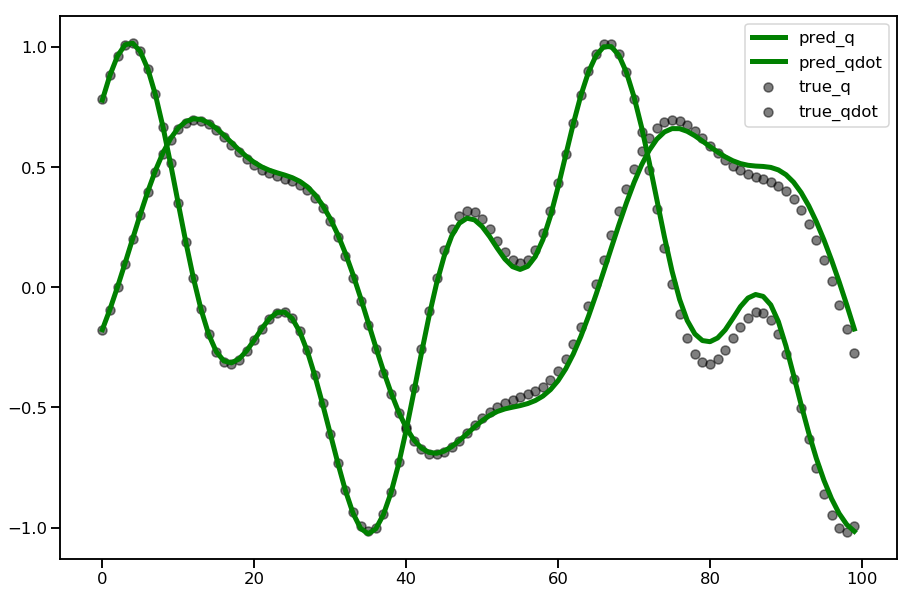

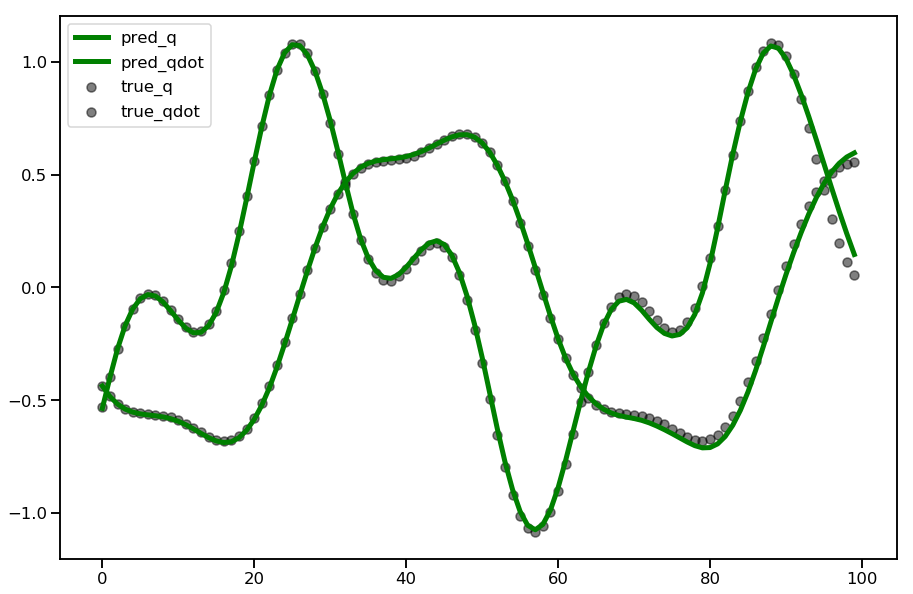

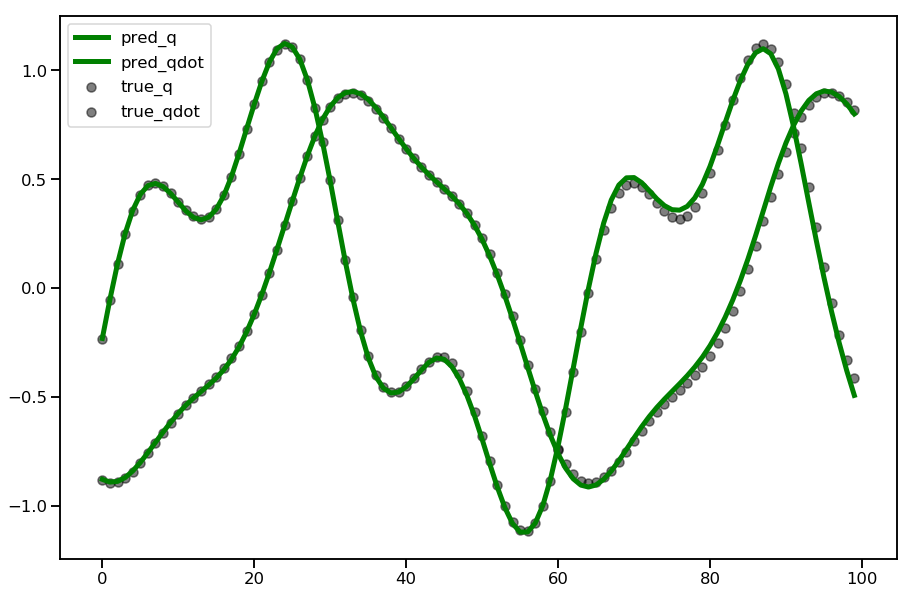

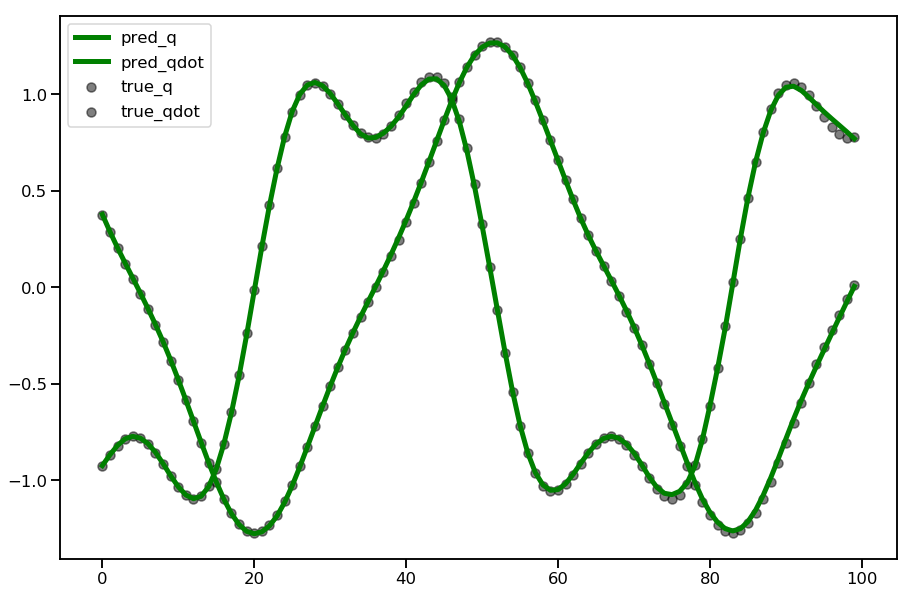

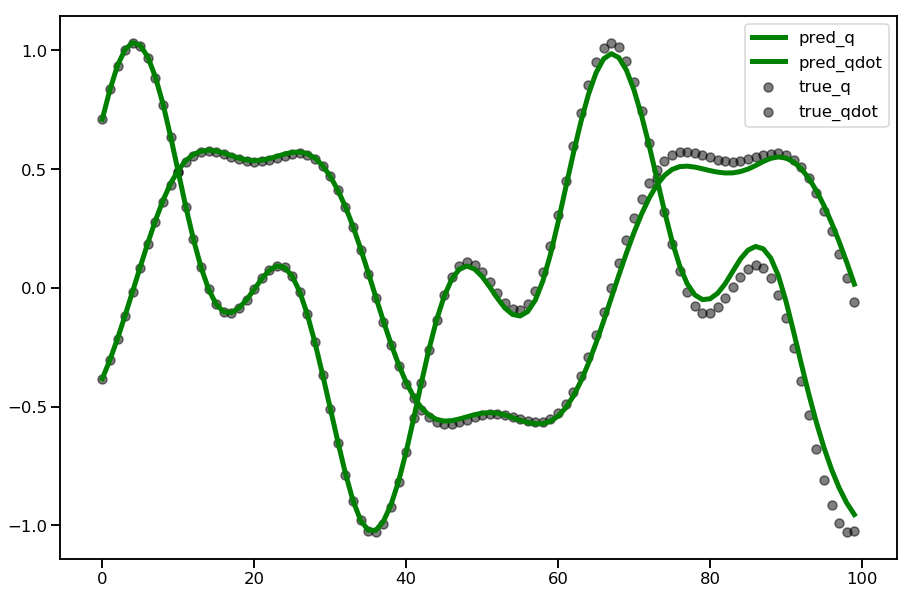

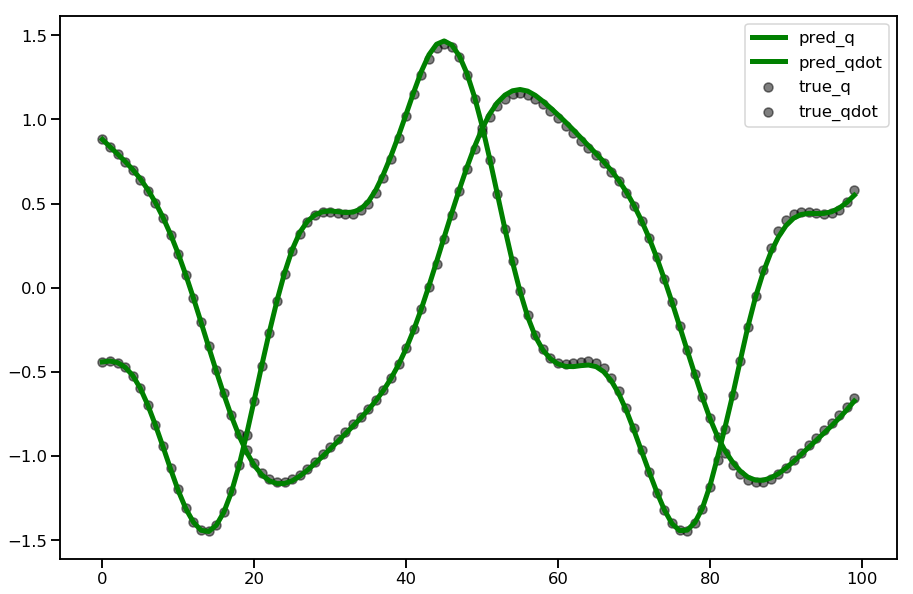

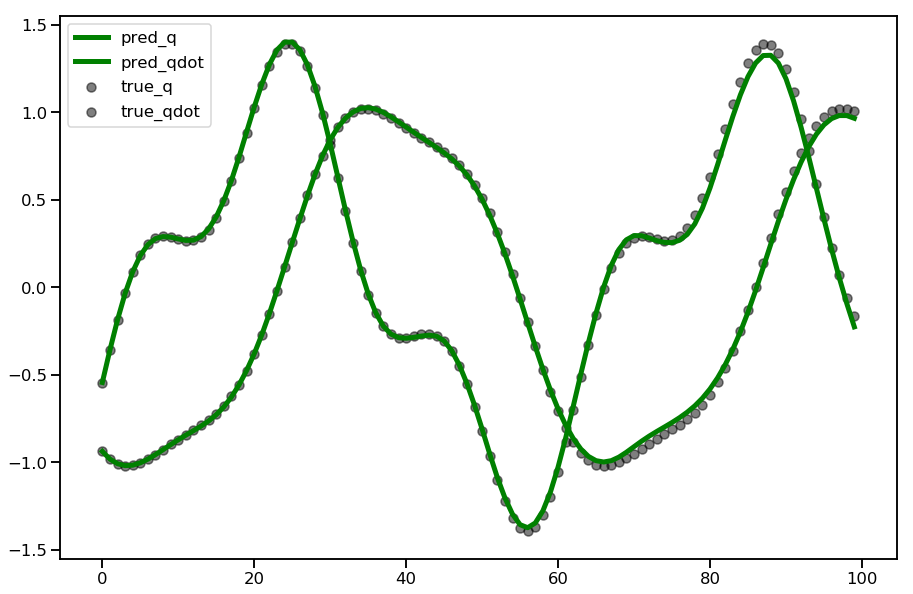

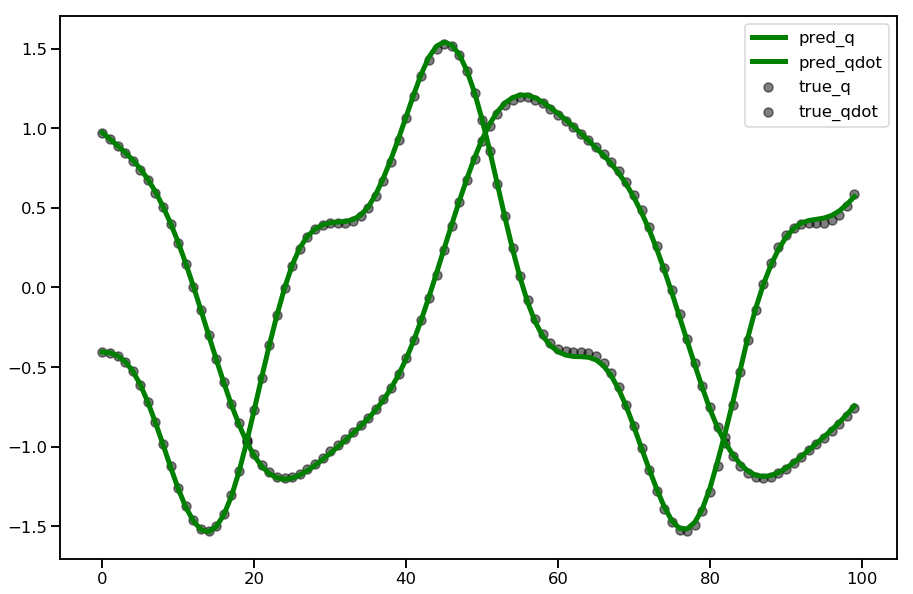

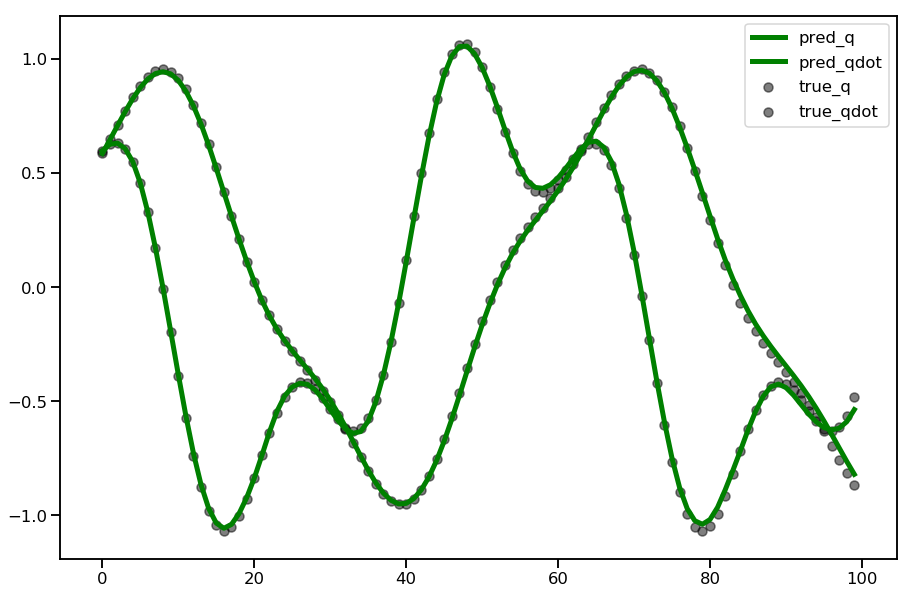

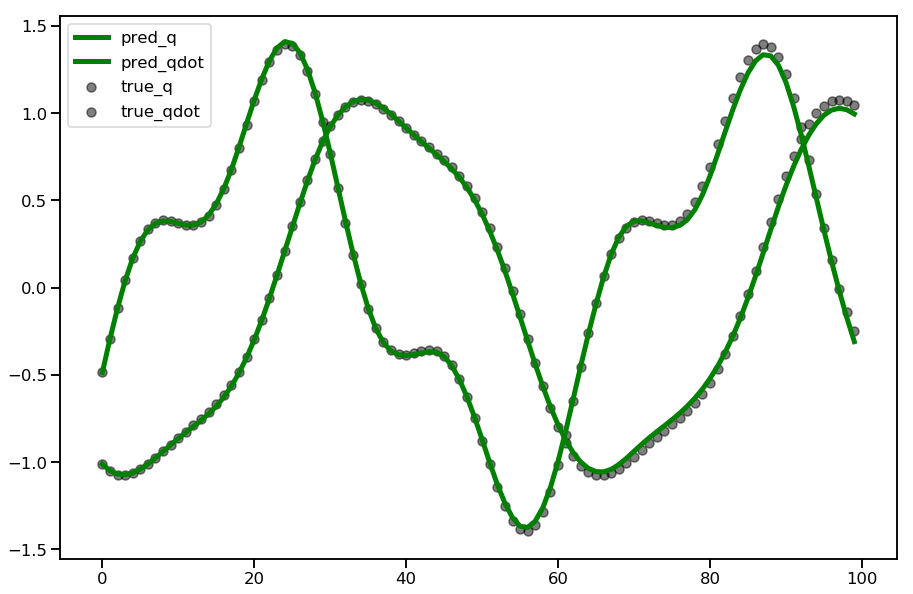

In [16]:
for j in range(n_test_traj):
    preds,q_next = main_pred[j]
    plt.figure(figsize=(15,10))
    plt.scatter(range(len(q_next)),q_next[:,0],c='black',label='true_q',alpha=.5)
    plt.scatter(range(len(q_next)),q_next[:,1],c='black',label='true_qdot',alpha=.5)
    plt.plot(preds[:,0],c='green',label='pred_q',linewidth=5.0)
    plt.plot(preds[:,1],c='green',label='pred_qdot',linewidth=5.0)
    plt.legend(loc='best')

In [56]:
def calc_deri(yvec, time):
    mass = 1  # kg
    b = 1
    g = 9.81
    r = 1
    f0 = 1
    omega = .3

    return (yvec[1],  -yvec[0] + f0 * np.cos(omega * time) / (mass * r))

def get_trajectory(radius=None, y0=None):
    # get initial state
    if y0 is None:
        y0 = np.random.rand(2) * 2 - 1
    if radius is None:
        radius = np.sqrt(np.random.uniform(0.5, 1.5))  # np.random.rand() * 0.9 + 0.1  # sample a range of radii
    y0 = y0 / np.sqrt((y0 ** 2).sum()) * (radius)  ## set the appropriate radius
    time_vec = np.arange(0, 10.01, 0.01)
    yinit = y0
    accum = odeint(calc_deri, yinit, time_vec)
    derivs = [calc_deri(accum[i], time_vec[i]) for i in range(len(accum))]
    return accum, derivs, time_vec


In [57]:
a,b,c = get_trajectory()

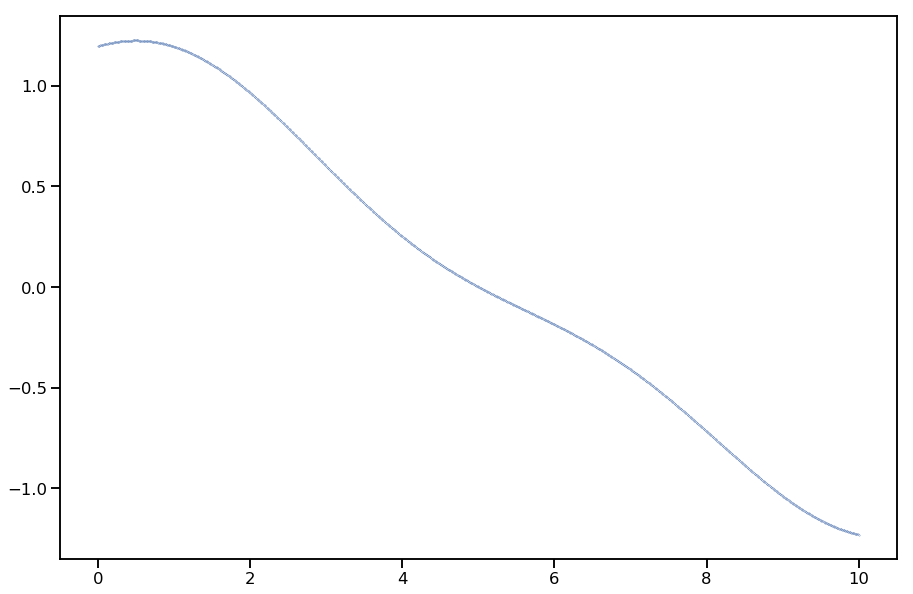

In [58]:
plt.figure(figsize=(15,10))
plt.scatter(c,a[:,0],s=0.1)

In [1]:
def permutation_tensor( n):
    M = torch.eye(n)
    M = torch.cat([M[n // 2:], -M[:n // 2]])
    return M

In [4]:
import torch
permutation_tensor(2).t()

tensor([[ 0., -1.],
        [ 1., -0.]])